In [6]:
## UROP exploration
# Study on HITLAPOMDPirconEnvironment with POMDP (using votes) against HITLDRNAgent
# Converges!
# Trying different learning parameters with same agent
# TODO:


# Training HITLDRQAgent appears to not converge using default learning parameters WHEN hiddent states are not reset after every episode
# NOTE: Hidden state is reset at the start of any episode during training -> reward values might be affected whenever there is a change in hidden states

In [7]:
# Import and initialise device param
import time
from models.BaseAgent import BaseAgent
import gymnasium as gym
import torch
import numpy as np
from gym_examples.utils.population import PopulationSimulation
from models.HITLDQNAgent import HITLDQNAgent
from models.HITLDRQNAgent import HITLDRQNAgent

device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

In [8]:
def train(agent:BaseAgent, env:gym.Env, episodes: int, device, is_exploring:bool):
    """Train agent using gym environment while being offline"""

    rewards = []

    agent.reset_replay_memory() # Same train function has the same episodic memory
    agent.set_exploring(True)

    for i_episode in range(episodes):
        print(f'######------------------------------------EPISODE {i_episode}------------------------------------######')
        observation, info = env.reset()
        state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        ep_rewards = 0
        is_done = False

        i = 0
        while not is_done:
            print("----Step----")
            # start = time.time()
            # start_a = time.time()
            action = agent.select_action(state)
            # end_a = time.time()
            # print(f'Action selection duration:{end_a-start_a}')
            # start_s = time.time()
            observation, reward, terminated, truncated, info = env.step(action.item())
            # end_s = time.time()
            # print(f'Step duration:{end_s-start_s}')
            reward = torch.tensor([np.float32(reward)], device=device)
            ep_rewards += reward
            
            is_done = terminated or truncated
            next_state = None if terminated else torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
            # start_m = time.time()
            agent.memorize(state, action, next_state, reward)
            # end_m = time.time()
            # print(f'Memorize duration:{end_m - start_m}')
            state = next_state
            # start_o = time.time()
            agent.optimize_model()
            # end_o = time.time()
            # print(f'Optimization selection duration:{end_o-start_o}')

            # end = time.time()
            # print(f'Iteration duration:{end-start}')

        rewards.append(ep_rewards.item())
            
    return agent, rewards

In [9]:
def train_w_reset_h(agent:BaseAgent, env:gym.Env, episodes: int, device, is_exploring:bool):
    """Train agent using gym environment while being offline"""

    rewards = []

    agent.reset_replay_memory() # Same train function has the same episodic memory
    agent.set_exploring(True)

    i = 0 # TODO: Remove

    for i_episode in range(episodes):
        print(f'######------------------------------------EPISODE {i_episode}------------------------------------######')
        observation, info = env.reset()
        state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        ep_rewards = 0
        is_done = False

        while not is_done:
            # print("\n----Step----")
            # start = time.time()
            # start_a = time.time()
            action = agent.select_action(state)
            # end_a = time.time()
            # print(f'Action selection duration:{end_a-start_a}')
            # start_s = time.time()
            observation, reward, terminated, truncated, info = env.step(action.item())
            # end_s = time.time()
            # print(f'Step duration:{end_s-start_s}')
            reward = torch.tensor([np.float32(reward)], device=device)
            ep_rewards += reward
            
            is_done = terminated or truncated
            next_state = None if terminated else torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
            # start_m = time.time()
            agent.memorize(state, action, next_state, reward)
            # end_m = time.time()
            # print(f'Memorize duration:{end_m - start_m}')
            state = next_state
            # start_o = time.time()
            agent.optimize_model()
            # end_o = time.time()
            # print(f'Optimization selection duration:{end_o-start_o}')

            # end = time.time()
            # print(f'Iteration duration:{end-start}')


        rewards.append(ep_rewards.item())

        agent.reset_hidden_state() # Reset the hidden state of the agent

    return agent, rewards

In [12]:
# Default training parameters

# population = PopulationSimulation(2.9, 1.05, 0.5, 0.25, 200, 80)
population = PopulationSimulation(2.9, 1.05, 0.5, 0.25, 10, 2)

# w_energy, w_usercomfort is from generated from a comfort score of range (-40 - 0) and power score (-1000 - -300) 100:1
env = gym.make("HITLAPOMDPirconEnvironment-v0", population_simulation=population, is_render=False, check_optimal=False ,w_usercomfort=1)
print("######------------------------------------Resetting environment...------------------------------------######")

state, info = env.reset()
n_observations = len(state)
n_actions = env.action_space.n

agent = HITLDRQNAgent(n_observations, n_actions, device, 
                     memory_size=10000, 
                     batch_size=64, 
                     gamma=0.99, 
                     eps_start=0.9, 
                     eps_end=0.05, 
                     eps_decay=1000, 
                     tau=0.005, 
                     lr=1e-4)

NUM_EPISODES = 700 if torch.cuda.is_available() or torch.backends.mps.is_available() else 50 # Number of days (each episode is a day)
# NUM_EPISODES = 20 if torch.cuda.is_available() or torch.backends.mps.is_available() else 50 # Number of days (each episode is a day)

print("######------------------------------------Starting training...------------------------------------######")
agent, rewards = train_w_reset_h(agent, env, NUM_EPISODES, device, True)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(rewards, label='total')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Comparison (Using Average Reward)')
plt.legend()

plt.ioff()
plt.show()

######------------------------------------Resetting environment...------------------------------------######
######------------------------------------Starting training...------------------------------------######
######------------------------------------EPISODE 0------------------------------------######
######------------------------------------EPISODE 1------------------------------------######
######------------------------------------EPISODE 2------------------------------------######
######------------------------------------EPISODE 3------------------------------------######
######------------------------------------EPISODE 4------------------------------------######
######------------------------------------EPISODE 5------------------------------------######
######------------------------------------EPISODE 6------------------------------------######
######------------------------------------EPISODE 7------------------------------------######
######----------------------------

KeyboardInterrupt: 

In [ ]:
# No convergence - Train without resetting hidden state
agent = HITLDRQNAgent(n_observations, n_actions, device, 
                     memory_size=10000, 
                     batch_size=64, 
                     gamma=0.99, 
                     eps_start=0.9, 
                     eps_end=0.05, 
                     eps_decay=1000, 
                     tau=0.005, 
                     lr=1e-4)

NUM_EPISODES = 700 if torch.cuda.is_available() or torch.backends.mps.is_available() else 50 # Number of days (each episode is a day)

print("######------------------------------------Starting training...------------------------------------######")
agent, rewards = train(agent, env, NUM_EPISODES, device, True)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(rewards, label='total')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Comparison (Using Average Reward)')
plt.legend()

plt.ioff()
plt.show()

######------------------------------------Starting training...------------------------------------######
######------------------------------------EPISODE 0------------------------------------######
4 0     6
1     6
2     4
3     6
4     5
5     5
6     6
7     6
8     4
9     4
10    6
dtype: int64 0     4
1     4
2     2
3     4
4     3
5     3
6     4
7     4
8     2
9     2
10    4
dtype: int64
----Step----
-6 4    -1
8    -2
0    -3
1    -1
2    -1
3    -1
4    -3
5    -1
6    -1
7    -6
8    -1
9    -1
10   -1
11   -1
dtype: int64 4     2
8     1
0     0
1     2
2     2
3     2
4     0
5     2
6     2
7    -3
8     2
9     2
10    2
11    2
dtype: int64


ValueError: 'list' argument must have no negative elements

######------------------------------------Starting training...------------------------------------######
######------------------------------------EPISODE 0------------------------------------######
######------------------------------------EPISODE 1------------------------------------######
######------------------------------------EPISODE 2------------------------------------######
######------------------------------------EPISODE 3------------------------------------######
######------------------------------------EPISODE 4------------------------------------######
######------------------------------------EPISODE 5------------------------------------######
######------------------------------------EPISODE 6------------------------------------######
######------------------------------------EPISODE 7------------------------------------######
######------------------------------------EPISODE 8------------------------------------######
######------------------------------------EPISODE

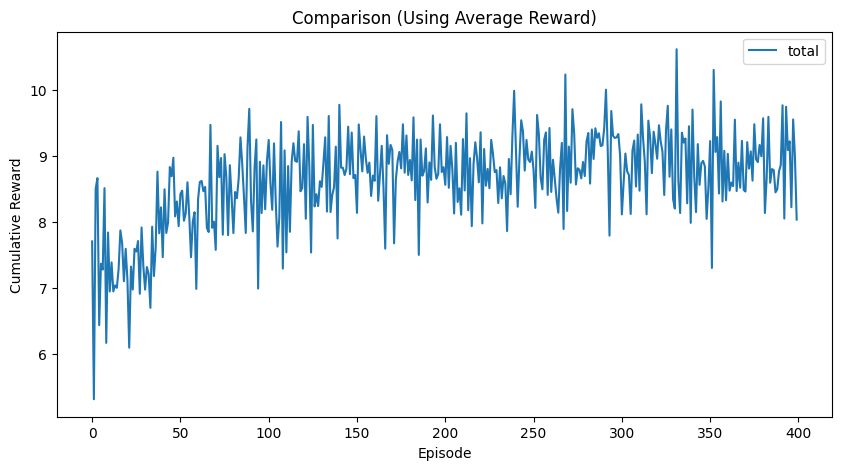

In [ ]:
# Increase batch_size 
agent = HITLDRQNAgent(n_observations, n_actions, device, 
                     memory_size=10000, 
                     batch_size=128, 
                     gamma=0.99, 
                     eps_start=0.9, 
                     eps_end=0.05, 
                     eps_decay=1000, 
                     tau=0.005, 
                     lr=1e-4)

NUM_EPISODES = 400 if torch.cuda.is_available() or torch.backends.mps.is_available() else 50 # Number of days (each episode is a day)

print("######------------------------------------Starting training...------------------------------------######")
agent, rewards = train_w_reset_h(agent, env, NUM_EPISODES, device, True)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(rewards, label='total')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Comparison (Using Average Reward)')
plt.legend()

plt.ioff()
plt.show()

######------------------------------------Starting training...------------------------------------######
######------------------------------------EPISODE 0------------------------------------######
######------------------------------------EPISODE 1------------------------------------######
######------------------------------------EPISODE 2------------------------------------######
######------------------------------------EPISODE 3------------------------------------######
######------------------------------------EPISODE 4------------------------------------######
######------------------------------------EPISODE 5------------------------------------######
######------------------------------------EPISODE 6------------------------------------######
######------------------------------------EPISODE 7------------------------------------######
######------------------------------------EPISODE 8------------------------------------######
######------------------------------------EPISODE

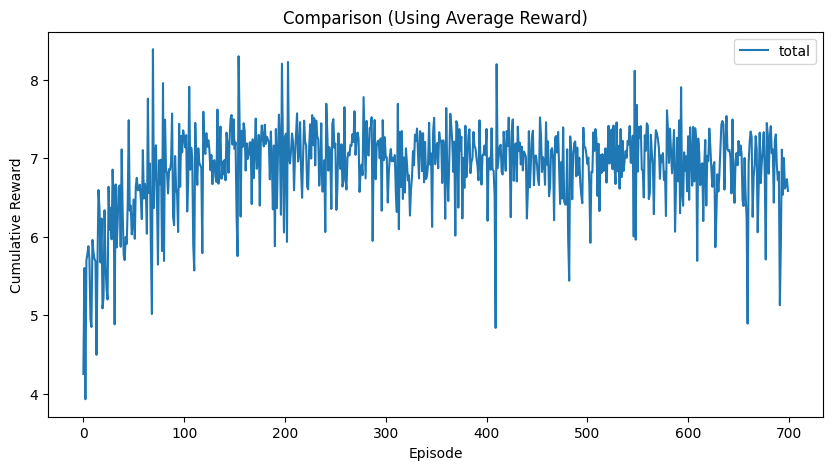

In [ ]:
# Increase learning rate lr=1e-3
agent = HITLDRQNAgent(n_observations, n_actions, device, 
                     memory_size=10000, 
                     batch_size=64, 
                     gamma=0.99, 
                     eps_start=0.9, 
                     eps_end=0.05, 
                     eps_decay=1000, 
                     tau=0.005, 
                     lr=1e-3)

NUM_EPISODES = 700 if torch.cuda.is_available() or torch.backends.mps.is_available() else 50 # Number of days (each episode is a day)

print("######------------------------------------Starting training...------------------------------------######")
agent, rewards = train_w_reset_h(agent, env, NUM_EPISODES, device, True)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(rewards, label='total')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Comparison (Using Average Reward)')
plt.legend()

plt.ioff()
plt.show()

######------------------------------------Starting training...------------------------------------######
######------------------------------------EPISODE 0------------------------------------######
######------------------------------------EPISODE 1------------------------------------######
######------------------------------------EPISODE 2------------------------------------######
######------------------------------------EPISODE 3------------------------------------######
######------------------------------------EPISODE 4------------------------------------######
######------------------------------------EPISODE 5------------------------------------######
######------------------------------------EPISODE 6------------------------------------######
######------------------------------------EPISODE 7------------------------------------######
######------------------------------------EPISODE 8------------------------------------######
######------------------------------------EPISODE

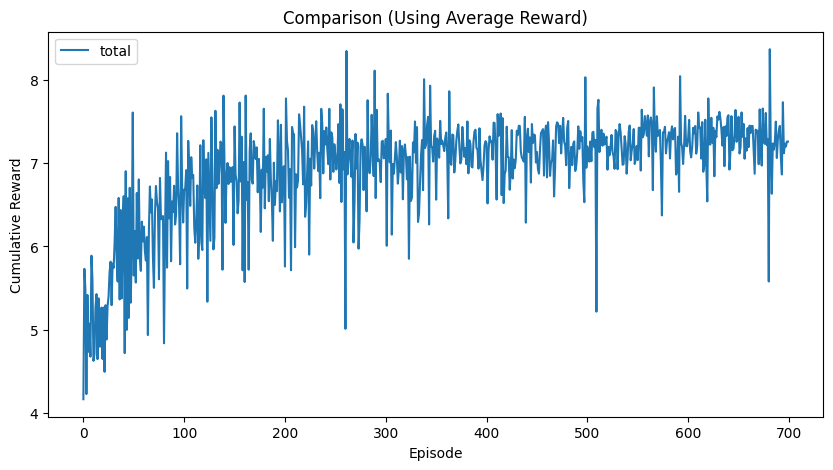

In [ ]:
# Increase eps_decay = 2000, slower decay
agent = HITLDRQNAgent(n_observations, n_actions, device, 
                     memory_size=10000, 
                     batch_size=64, 
                     gamma=0.99, 
                     eps_start=0.9, 
                     eps_end=0.05, 
                     eps_decay=2000, 
                     tau=0.005, 
                     lr=1e-4)

NUM_EPISODES = 700 if torch.cuda.is_available() or torch.backends.mps.is_available() else 50 # Number of days (each episode is a day)

print("######------------------------------------Starting training...------------------------------------######")
agent, rewards = train_w_reset_h(agent, env, NUM_EPISODES, device, True)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(rewards, label='total')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Comparison (Using Average Reward)')
plt.legend()

plt.ioff()
plt.show()

######------------------------------------Starting training...------------------------------------######
######------------------------------------EPISODE 0------------------------------------######
######------------------------------------EPISODE 1------------------------------------######
######------------------------------------EPISODE 2------------------------------------######
######------------------------------------EPISODE 3------------------------------------######
######------------------------------------EPISODE 4------------------------------------######
######------------------------------------EPISODE 5------------------------------------######
######------------------------------------EPISODE 6------------------------------------######
######------------------------------------EPISODE 7------------------------------------######
######------------------------------------EPISODE 8------------------------------------######
######------------------------------------EPISODE

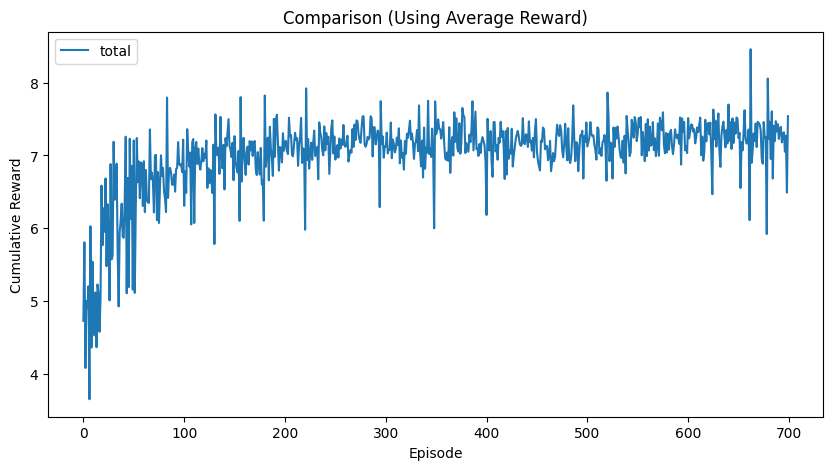

In [ ]:
# Increase tau = 0.01, target and policy networks are closer
agent = HITLDRQNAgent(n_observations, n_actions, device, 
                     memory_size=10000, 
                     batch_size=64, 
                     gamma=0.99, 
                     eps_start=0.9, 
                     eps_end=0.05, 
                     eps_decay=1000, 
                     tau=0.01, 
                     lr=1e-4)

NUM_EPISODES = 700 if torch.cuda.is_available() or torch.backends.mps.is_available() else 50 # Number of days (each episode is a day)

print("######------------------------------------Starting training...------------------------------------######")
agent, rewards = train_w_reset_h(agent, env, NUM_EPISODES, device, True)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(rewards, label='total')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Comparison (Using Average Reward)')
plt.legend()

plt.ioff()
plt.show()

######------------------------------------Starting training...------------------------------------######
######------------------------------------EPISODE 0------------------------------------######
######------------------------------------EPISODE 1------------------------------------######
######------------------------------------EPISODE 2------------------------------------######
######------------------------------------EPISODE 3------------------------------------######
######------------------------------------EPISODE 4------------------------------------######
######------------------------------------EPISODE 5------------------------------------######
######------------------------------------EPISODE 6------------------------------------######
######------------------------------------EPISODE 7------------------------------------######
######------------------------------------EPISODE 8------------------------------------######
######------------------------------------EPISODE

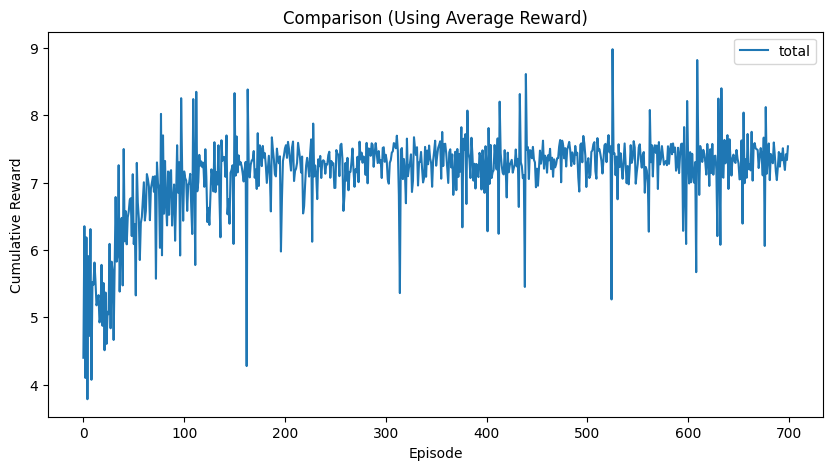

In [ ]:
# Decrease gamma = 0.9, less emphasis on future rewards
agent = HITLDRQNAgent(n_observations, n_actions, device, 
                     memory_size=10000, 
                     batch_size=64, 
                     gamma=0.90, 
                     eps_start=0.9, 
                     eps_end=0.05, 
                     eps_decay=1000, 
                     tau=0.005, 
                     lr=1e-4)

NUM_EPISODES = 700 if torch.cuda.is_available() or torch.backends.mps.is_available() else 50 # Number of days (each episode is a day)

print("######------------------------------------Starting training...------------------------------------######")
agent, rewards = train_w_reset_h(agent, env, NUM_EPISODES, device, True)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(rewards, label='total')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Comparison (Using Average Reward)')
plt.legend()

plt.ioff()
plt.show()

######------------------------------------Starting training...------------------------------------######
######------------------------------------EPISODE 0------------------------------------######
######------------------------------------EPISODE 1------------------------------------######
######------------------------------------EPISODE 2------------------------------------######
######------------------------------------EPISODE 3------------------------------------######
######------------------------------------EPISODE 4------------------------------------######
######------------------------------------EPISODE 5------------------------------------######
######------------------------------------EPISODE 6------------------------------------######
######------------------------------------EPISODE 7------------------------------------######
######------------------------------------EPISODE 8------------------------------------######
######------------------------------------EPISODE

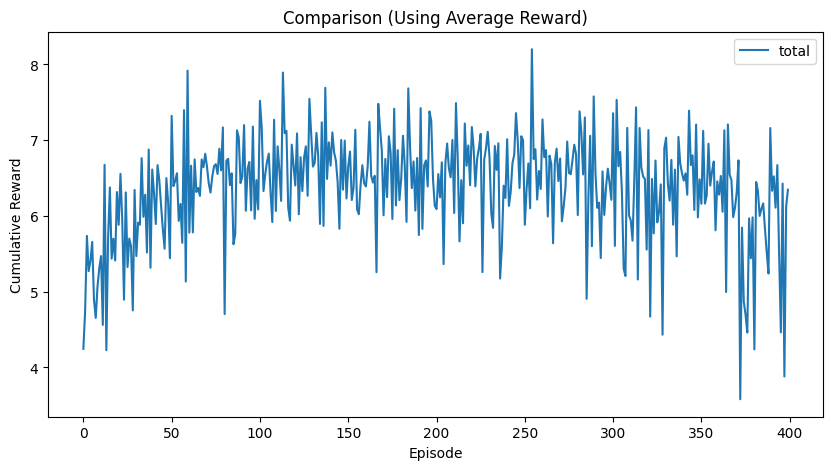

In [ ]:
# Increase lr=1e-2 
agent = HITLDRQNAgent(n_observations, n_actions, device, 
                     memory_size=10000, 
                     batch_size=64, 
                     gamma=0.99, 
                     eps_start=0.9, 
                     eps_end=0.05, 
                     eps_decay=1000, 
                     tau=0.005, 
                     lr=1e-2)

NUM_EPISODES = 400 if torch.cuda.is_available() or torch.backends.mps.is_available() else 50 # Number of days (each episode is a day)

print("######------------------------------------Starting training...------------------------------------######")
agent, rewards = train_w_reset_h(agent, env, NUM_EPISODES, device, True)

plt.figure(figsize=(10, 5))
plt.plot(rewards, label='total')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Comparison (Using Average Reward)')
plt.legend()

plt.ioff()
plt.show()

# Testing Trained agent with changing populations

In [ ]:
def test(agent:HITLDRQNAgent, env:gym.Env, episodes: int, device):
    print("######------------------------------------Starting test...------------------------------------######")

    rewards = []
    
    for i_episode in range(episodes):
        print(f'######------------------------------------EPISODE {i_episode}------------------------------------######')
        
        observation, info = env.reset()
        state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        ep_rewards = 0
        done = False

        i = 0
        while not done:
            action = agent.select_action(state)
            observation, reward, terminated, truncated, info = env.step(action.item())
            reward = torch.tensor([np.float32(reward)], device=device)
            ep_rewards += reward

            done = terminated or truncated
            next_state = None if terminated else torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

            state = next_state

        rewards.append(ep_rewards.item())
    agent.reset_hidden_state()
    return rewards

######------------------------------------Starting test...------------------------------------######
######------------------------------------EPISODE 0------------------------------------######
######------------------------------------EPISODE 1------------------------------------######
######------------------------------------EPISODE 2------------------------------------######
######------------------------------------EPISODE 3------------------------------------######
######------------------------------------EPISODE 4------------------------------------######
######------------------------------------EPISODE 5------------------------------------######
######------------------------------------EPISODE 6------------------------------------######
######------------------------------------EPISODE 7------------------------------------######
######------------------------------------EPISODE 8------------------------------------######
######------------------------------------EPISODE 9--

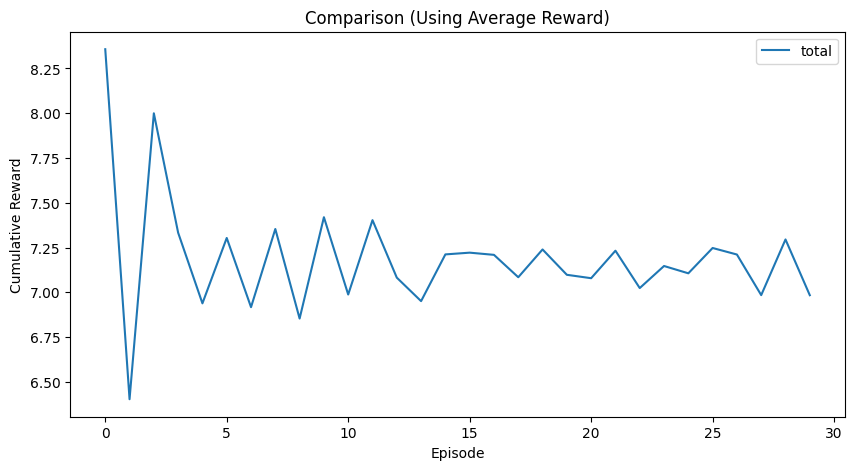

In [ ]:
# population_shift = PopulationSimulation(1, 1.05, 0.8, 0.25, 200, 80)
population = PopulationSimulation(2.9, 1.05, 0.5, 0.25, 200, 80)

env_shift = gym.make("HITLAPOMDPirconEnvironment-v0", population_simulation=population, is_render=False, check_optimal=False)
rewards = test(agent, env_shift, 30, device)

plt.figure(figsize=(10, 5))
plt.plot(rewards, label='total')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Comparison (Using Average Reward)')
plt.legend()

plt.ioff()
plt.show()

######------------------------------------Starting test...------------------------------------######
######------------------------------------EPISODE 0------------------------------------######
######------------------------------------EPISODE 1------------------------------------######
######------------------------------------EPISODE 2------------------------------------######
######------------------------------------EPISODE 3------------------------------------######
######------------------------------------EPISODE 4------------------------------------######
######------------------------------------EPISODE 5------------------------------------######
######------------------------------------EPISODE 6------------------------------------######
######------------------------------------EPISODE 7------------------------------------######
######------------------------------------EPISODE 8------------------------------------######
######------------------------------------EPISODE 9--

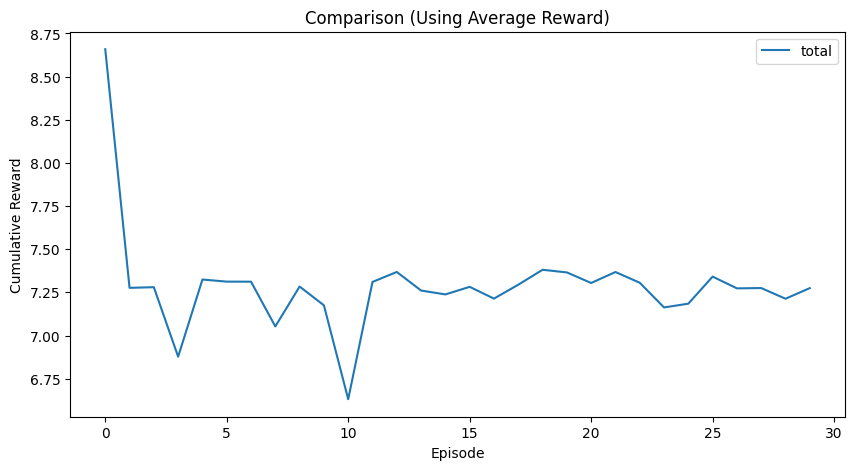

In [ ]:
population_shift = PopulationSimulation(2.9, 1.05, 0.5, 0.25, 1000, 100)
# population = PopulationSimulation(2.9, 1.05, 0.5, 0.25, 200, 80)

env_shift = gym.make("HITLAPOMDPirconEnvironment-v0", population_simulation=population_shift, is_render=False, check_optimal=False)
rewards = test(agent, env_shift, 30, device)

plt.figure(figsize=(10, 5))
plt.plot(rewards, label='total')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Comparison (Using Average Reward)')
plt.legend()

plt.ioff()
plt.show()

######------------------------------------Starting test...------------------------------------######
######------------------------------------EPISODE 0------------------------------------######
######------------------------------------EPISODE 1------------------------------------######
######------------------------------------EPISODE 2------------------------------------######
######------------------------------------EPISODE 3------------------------------------######
######------------------------------------EPISODE 4------------------------------------######
######------------------------------------EPISODE 5------------------------------------######
######------------------------------------EPISODE 6------------------------------------######
######------------------------------------EPISODE 7------------------------------------######
######------------------------------------EPISODE 8------------------------------------######
######------------------------------------EPISODE 9--

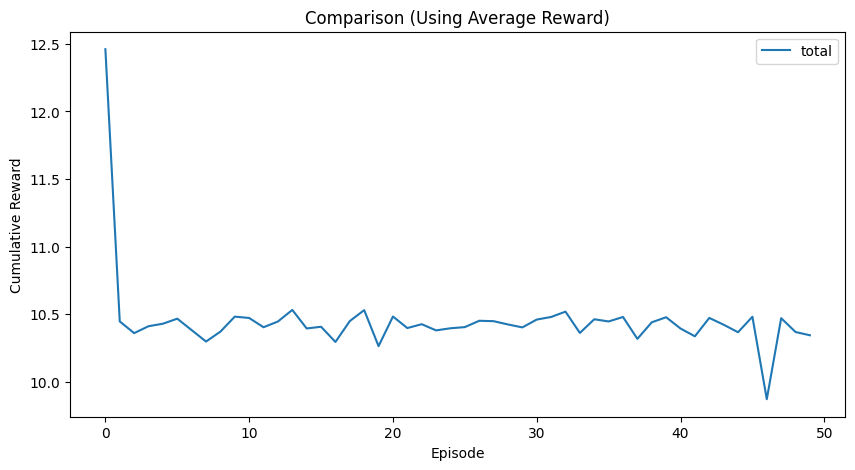

In [ ]:
population = PopulationSimulation(2.9, 1.05, 0.5, 0.25, 200, 80)

env_shift = gym.make("HITLAPOMDPirconEnvironment-v0", population_simulation=population_shift, is_render=False, check_optimal=False)
rewards = test(agent, env_shift, 50, device)

plt.figure(figsize=(10, 5))
plt.plot(rewards, label='total')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Comparison (Using Average Reward)')
plt.legend()

plt.ioff()
plt.show()